In [244]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder,StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
#from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score

In [3]:
data = pd.read_csv('/content/diabetic_data.csv')

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

In [5]:
# checking null values
data.isnull().sum()

encounter_id                0
patient_nbr                 0
race                        0
gender                      0
age                         0
weight                      0
admission_type_id           0
discharge_disposition_id    0
admission_source_id         0
time_in_hospital            0
payer_code                  0
medical_specialty           0
num_lab_procedures          0
num_procedures              0
num_medications             0
number_outpatient           0
number_emergency            0
number_inpatient            0
diag_1                      0
diag_2                      0
diag_3                      0
number_diagnoses            0
max_glu_serum               0
A1Cresult                   0
metformin                   0
repaglinide                 0
nateglinide                 0
chlorpropamide              0
glimepiride                 0
acetohexamide               0
glipizide                   0
glyburide                   0
tolbutamide                 0
pioglitazo

In [15]:
## checking values in data
for cols in data.columns:
  if type(data[cols][0]) == str:
    print(cols, data[cols].unique())

race ['Caucasian' 'AfricanAmerican' '?' 'Other' 'Asian' 'Hispanic']
gender ['Female' 'Male' 'Unknown/Invalid']
age ['[0-10)' '[10-20)' '[20-30)' '[30-40)' '[40-50)' '[50-60)' '[60-70)'
 '[70-80)' '[80-90)' '[90-100)']
weight ['?' '[75-100)' '[50-75)' '[0-25)' '[100-125)' '[25-50)' '[125-150)'
 '[175-200)' '[150-175)' '>200']
payer_code ['?' 'MC' 'MD' 'HM' 'UN' 'BC' 'SP' 'CP' 'SI' 'DM' 'CM' 'CH' 'PO' 'WC' 'OT'
 'OG' 'MP' 'FR']
medical_specialty ['Pediatrics-Endocrinology' '?' 'InternalMedicine'
 'Family/GeneralPractice' 'Cardiology' 'Surgery-General' 'Orthopedics'
 'Gastroenterology' 'Surgery-Cardiovascular/Thoracic' 'Nephrology'
 'Orthopedics-Reconstructive' 'Psychiatry' 'Emergency/Trauma'
 'Pulmonology' 'Surgery-Neuro' 'Obsterics&Gynecology-GynecologicOnco'
 'ObstetricsandGynecology' 'Pediatrics' 'Hematology/Oncology'
 'Otolaryngology' 'Surgery-Colon&Rectal' 'Pediatrics-CriticalCare'
 'Endocrinology' 'Urology' 'Psychiatry-Child/Adolescent'
 'Pediatrics-Pulmonology' 'Neurology' 'Anesth

**Data Cleaning**

In [14]:
type(data[cols])

pandas.core.series.Series

In [97]:
# drop bad data ("?") in race column
df = data.copy()
df = df.drop(df[df["race"] == "?"].index)

In [98]:
df[df["gender"] == 'Unknown/Invalid'].index

Int64Index([30506], dtype='int64')

In [99]:
# drop 'Unknown/Invalid' in gender column
df  = df.drop(df[df["gender"] == 'Unknown/Invalid'].index)

In [100]:
df

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,443847548,100162476,AfricanAmerican,Male,[70-80),?,1,3,7,3,...,No,Down,No,No,No,No,No,Ch,Yes,>30
101762,443847782,74694222,AfricanAmerican,Female,[80-90),?,1,4,5,5,...,No,Steady,No,No,No,No,No,No,Yes,NO
101763,443854148,41088789,Caucasian,Male,[70-80),?,1,1,7,1,...,No,Down,No,No,No,No,No,Ch,Yes,NO
101764,443857166,31693671,Caucasian,Female,[80-90),?,2,3,7,10,...,No,Up,No,No,No,No,No,Ch,Yes,NO


In [101]:
#Cleaning age data apply average from the range
def age_clean(x):
  l = x.split('-')
  x1 = int(l[0][1:])
  x2 = int(l[1][:-1])
  return int((x1+x2)/2)
df["age"] = df["age"].apply(lambda x: age_clean(x))

In [102]:
#Cleaning weight data apply average from the range
df = df.drop(df[df["weight"] == "?"].index)
def weight_clean(x):
  if  ">" not in x:
    l = x.split('-')
    x1 = int(l[0][1:])
    x2 = int(l[1][:-1])
    return int((x1+x2)/2)
  else:
    return int(x[1:])
df["weight"] = df["weight"].apply(lambda x: weight_clean(x))

In [103]:
df["weight"].unique()

array([ 87,  12,  62, 112,  37, 137, 162, 200, 187])

In [104]:
df

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
1102,8042082,94466574,Caucasian,Male,55,87,6,1,17,2,...,No,Steady,No,No,No,No,No,No,Yes,>30
1132,8235036,79874631,Caucasian,Female,65,12,6,1,17,5,...,No,Steady,No,No,No,No,No,Ch,Yes,>30
1136,8274126,90421380,Caucasian,Female,45,87,6,1,17,3,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
1190,8421486,55628172,Caucasian,Female,75,87,6,6,17,11,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
1204,8576406,80041266,Caucasian,Female,85,62,6,1,17,9,...,No,Steady,No,No,No,No,No,Ch,Yes,>30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101456,439606454,113392368,AfricanAmerican,Male,65,87,2,1,1,2,...,No,No,No,No,No,No,No,No,No,>30
101516,440252540,97508430,Caucasian,Male,65,112,1,1,7,4,...,No,No,No,No,No,No,No,Ch,Yes,>30
101640,442077494,62420742,Caucasian,Female,75,62,1,3,7,8,...,No,Steady,No,No,No,No,No,No,Yes,NO
101667,442577684,78208677,Caucasian,Male,75,87,1,3,7,4,...,No,No,No,No,No,No,No,Ch,Yes,<30


In [105]:
# encode readmitting
df['readmitted'] = df['readmitted'].replace('>30', 1)
df['readmitted'] = df['readmitted'].replace('<30', 1)
df['readmitted'] = df['readmitted'].replace('NO', 0)


In [106]:
# medicine Columns
medicine = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'glipizide', 'glyburide',
            'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'insulin', 'glyburide-metformin', 'tolazamide',
            'metformin-pioglitazone', 'metformin-rosiglitazone', 'glimepiride-pioglitazone', 'glipizide-metformin',
            'troglitazone', 'tolbutamide', 'acetohexamide']
for med in medicine:
    tmp = med + 'temp'
    df[tmp] = df[med].apply(lambda x: 1 if (x == 'Down' or x == 'Up') else 0)
df['num_med_changed'] = 0
for med in medicine:
    tmp = med + 'temp'
    df['num_med_changed'] += df[tmp]
    del df[tmp]
for i in medicine:
    df[i] = df[i].replace('Steady', 1)
    df[i] = df[i].replace('No', 0)
    df[i] = df[i].replace('Up', 1)
    df[i] = df[i].replace('Down', 1)
df['num_med_taken'] = 0
for med in medicine:
    print(med)
    df['num_med_taken'] = df['num_med_taken'] + df[med]

metformin
repaglinide
nateglinide
chlorpropamide
glimepiride
glipizide
glyburide
pioglitazone
rosiglitazone
acarbose
miglitol
insulin
glyburide-metformin
tolazamide
metformin-pioglitazone
metformin-rosiglitazone
glimepiride-pioglitazone
glipizide-metformin
troglitazone
tolbutamide
acetohexamide


In [107]:
# encoding Race Column
lb = LabelEncoder()
df["race"] = lb.fit_transform(df["race"])
lb.classes_

array(['AfricanAmerican', 'Asian', 'Caucasian', 'Other'], dtype=object)

In [108]:
df['A1Cresult'] = df['A1Cresult'].replace('None', -99)  # -1 -> -99
df['A1Cresult'] = df['A1Cresult'].replace('>8', 1)
df['A1Cresult'] = df['A1Cresult'].replace('>7', 1)
df['A1Cresult'] = df['A1Cresult'].replace('Norm', 0)


In [109]:
df['max_glu_serum'] = df['max_glu_serum'].replace('>200', 1)
df['max_glu_serum'] = df['max_glu_serum'].replace('>300', 1)
df['max_glu_serum'] = df['max_glu_serum'].replace('Norm', 0)
df['max_glu_serum'] = df['max_glu_serum'].replace('None', -99)  # -1 -> -99


In [110]:
# gender
lb = LabelEncoder()
df["gender"] = lb.fit_transform(df["gender"])
lb.classes_

array(['Female', 'Male'], dtype=object)

In [111]:
# change
lb = LabelEncoder()
df["change"] = lb.fit_transform(df["change"])
lb.classes_

array(['Ch', 'No'], dtype=object)

In [112]:
# change
lb = LabelEncoder()
df['diabetesMed'] = lb.fit_transform(df['diabetesMed'])
lb.classes_

array(['No', 'Yes'], dtype=object)

In [113]:
# droping diag data
df = df.drop(["diag_1","diag_3","diag_2"],axis=1)

In [114]:
# drop id's
df = df.drop(['encounter_id','admission_type_id','discharge_disposition_id','admission_source_id'],axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3059 entries, 1102 to 101723
Data columns (total 45 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   patient_nbr               3059 non-null   int64 
 1   race                      3059 non-null   int64 
 2   gender                    3059 non-null   int64 
 3   age                       3059 non-null   int64 
 4   weight                    3059 non-null   int64 
 5   time_in_hospital          3059 non-null   int64 
 6   payer_code                3059 non-null   object
 7   medical_specialty         3059 non-null   object
 8   num_lab_procedures        3059 non-null   int64 
 9   num_procedures            3059 non-null   int64 
 10  num_medications           3059 non-null   int64 
 11  number_outpatient         3059 non-null   int64 
 12  number_emergency          3059 non-null   int64 
 13  number_inpatient          3059 non-null   int64 
 14  number_diagnoses   

In [115]:
numerical = []
for cols in df.columns:
  if type(df[cols].values[0]) != "str":
    if cols != 'readmitted':
      numerical.append(cols)


In [116]:
numerical

['patient_nbr',
 'race',
 'gender',
 'age',
 'weight',
 'time_in_hospital',
 'payer_code',
 'medical_specialty',
 'num_lab_procedures',
 'num_procedures',
 'num_medications',
 'number_outpatient',
 'number_emergency',
 'number_inpatient',
 'number_diagnoses',
 'max_glu_serum',
 'A1Cresult',
 'metformin',
 'repaglinide',
 'nateglinide',
 'chlorpropamide',
 'glimepiride',
 'acetohexamide',
 'glipizide',
 'glyburide',
 'tolbutamide',
 'pioglitazone',
 'rosiglitazone',
 'acarbose',
 'miglitol',
 'troglitazone',
 'tolazamide',
 'examide',
 'citoglipton',
 'insulin',
 'glyburide-metformin',
 'glipizide-metformin',
 'glimepiride-pioglitazone',
 'metformin-rosiglitazone',
 'metformin-pioglitazone',
 'change',
 'diabetesMed',
 'num_med_changed',
 'num_med_taken']

# EDA

<ipython-input-117-f478ee291ced>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr())


<Axes: >

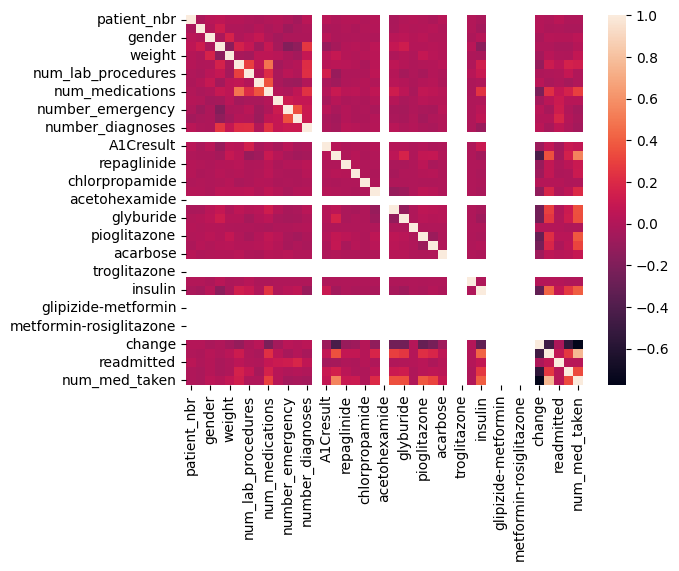

In [117]:
# corr map
sns.heatmap(df.corr())

In [134]:
def correlation(dataset, threshold):
    col_corr = set()
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
                if colname in dataset.columns:
                    del dataset[colname]

    return (dataset)

In [135]:
dataset = correlation(df,0.9)

<ipython-input-134-61b2415e1b63>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = dataset.corr()


In [141]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3059 entries, 1102 to 101723
Data columns (total 45 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   patient_nbr               3059 non-null   int64 
 1   race                      3059 non-null   int64 
 2   gender                    3059 non-null   int64 
 3   age                       3059 non-null   int64 
 4   weight                    3059 non-null   int64 
 5   time_in_hospital          3059 non-null   int64 
 6   payer_code                3059 non-null   object
 7   medical_specialty         3059 non-null   object
 8   num_lab_procedures        3059 non-null   int64 
 9   num_procedures            3059 non-null   int64 
 10  num_medications           3059 non-null   int64 
 11  number_outpatient         3059 non-null   int64 
 12  number_emergency          3059 non-null   int64 
 13  number_inpatient          3059 non-null   int64 
 14  number_diagnoses   

# Removing Multicollinearity

<ipython-input-199-aa6664222663>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(dataset.corr())


<Axes: >

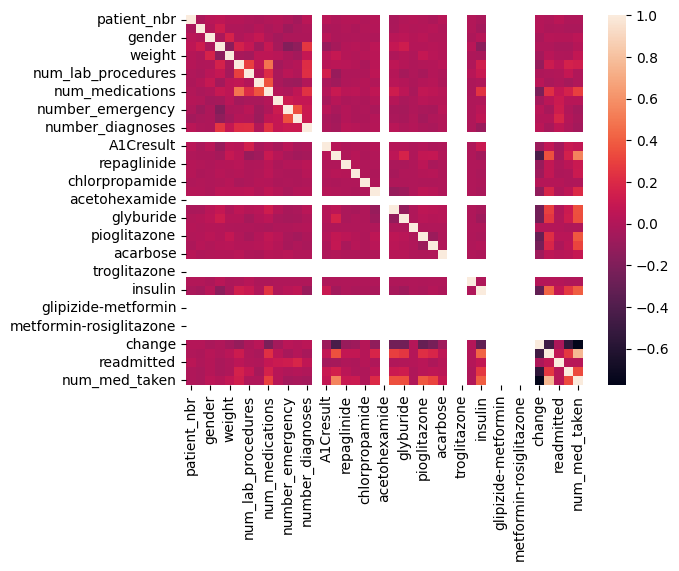

In [199]:
sns.heatmap(dataset.corr())

In [221]:
df_new = df.drop(['A1Cresult','miglitol','glipizide-metformin','max_glu_serum','acetohexamide','troglitazone','metformin-pioglitazone' ,'glimepiride-pioglitazone','glyburide-metformin','metformin-rosiglitazone'],axis=1)

<ipython-input-222-6b3f8e925a1e>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_new.corr())


<Axes: >

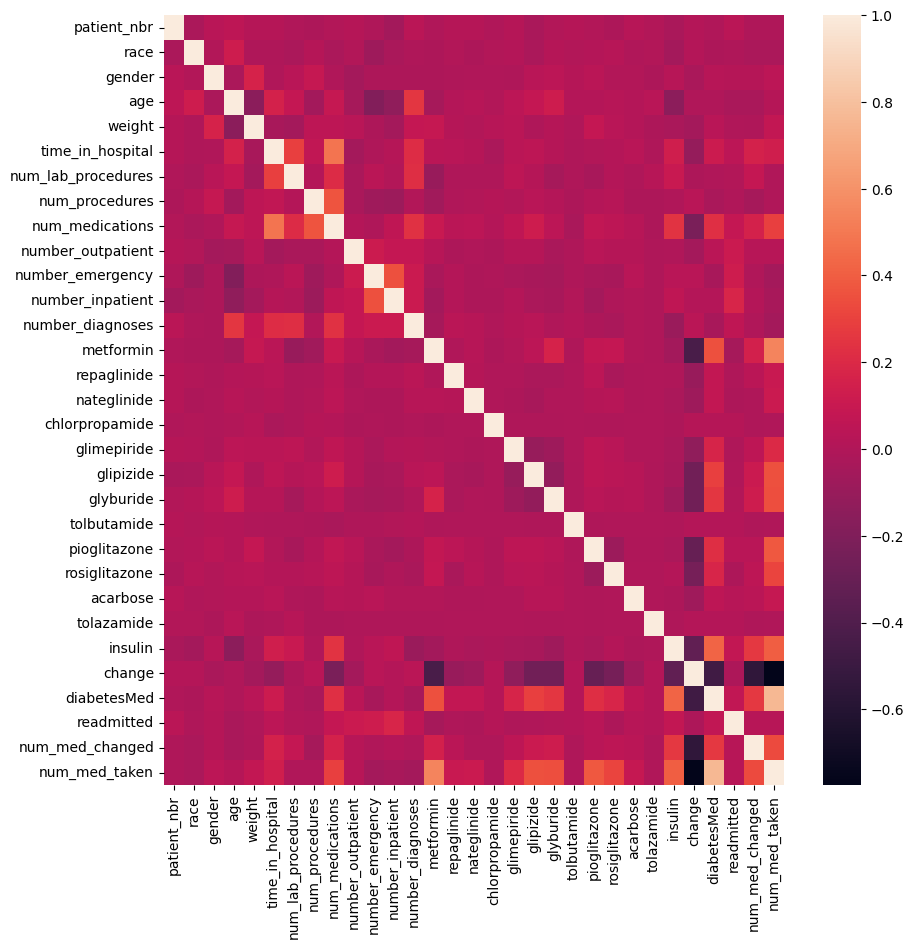

In [222]:
plt.figure(figsize=(10,10))
sns.heatmap(df_new.corr())

<ipython-input-223-06ef93e6be0e>:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  ax=sns.kdeplot(df_new.loc[(df_new['readmitted'] == 0),'num_lab_procedures'] , color='b',shade=True,label='Not readmitted')
<ipython-input-223-06ef93e6be0e>:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  ax=sns.kdeplot(df_new.loc[(df_new['readmitted'] == 1),'num_lab_procedures'] , color='r',shade=True, label='readmitted')


Text(0.5, 1.0, 'Number of lab procedure VS. Readmission')

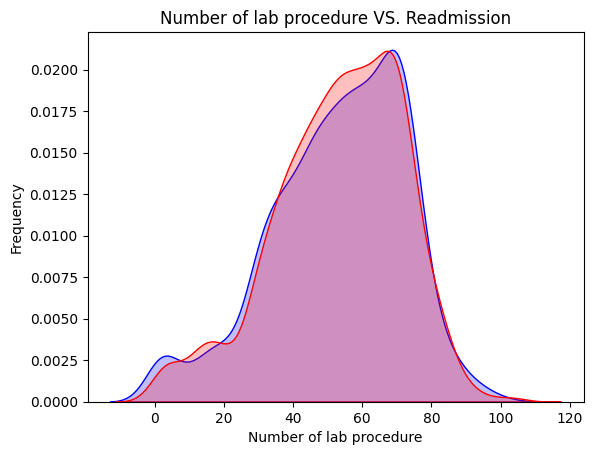

In [223]:

ax=sns.kdeplot(df_new.loc[(df_new['readmitted'] == 0),'num_lab_procedures'] , color='b',shade=True,label='Not readmitted')
ax=sns.kdeplot(df_new.loc[(df_new['readmitted'] == 1),'num_lab_procedures'] , color='r',shade=True, label='readmitted')
ax.set(xlabel='Number of lab procedure', ylabel='Frequency')
plt.title('Number of lab procedure VS. Readmission')

Text(0.5, 1.0, 'Diabetes Medication prescribed VS Readmission')

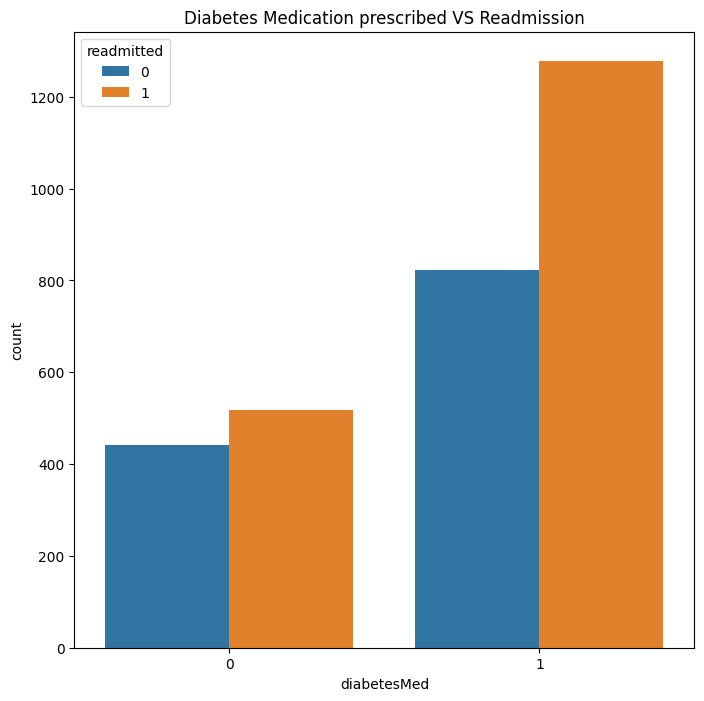

In [224]:
#“yes” : 1 “no” : 0
# diabetes prescribed patient readmitted count is high
fig = plt.figure(figsize=(8,8))
sns.countplot(x =df['diabetesMed'], hue = df['readmitted']).set_title('Diabetes Medication prescribed VS Readmission')

Text(0.5, 1.0, 'Gender of Patient VS. Readmission')

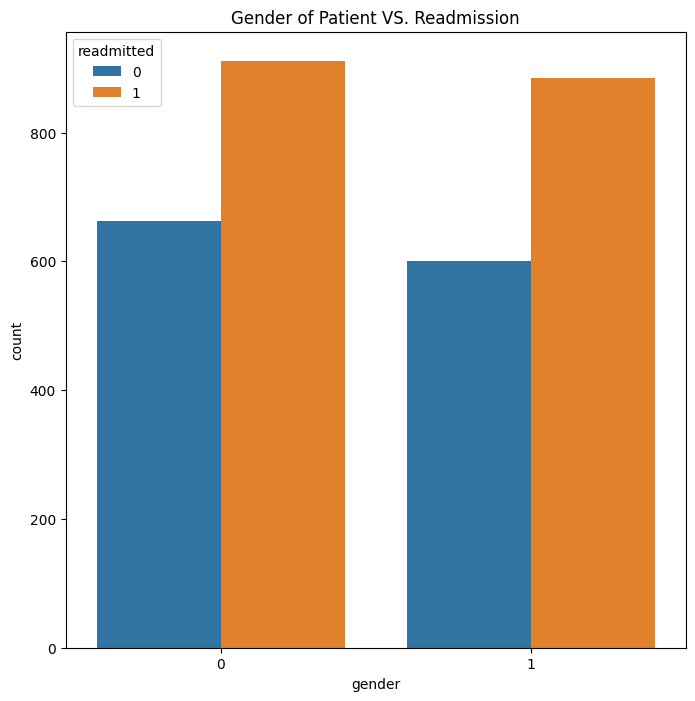

In [225]:
#Male = 1
#Female = 0
fig = plt.figure(figsize=(8,8))
sns.countplot(x =df['gender'], hue = df['readmitted']).set_title("Gender of Patient VS. Readmission")

In [226]:
numerical = []
for cols in df_new.columns:
  if type(df_new[cols].values[0]) != "str":
    if cols != 'readmitted':
      numerical.append(cols)


In [227]:
numerical

['patient_nbr',
 'race',
 'gender',
 'age',
 'weight',
 'time_in_hospital',
 'payer_code',
 'medical_specialty',
 'num_lab_procedures',
 'num_procedures',
 'num_medications',
 'number_outpatient',
 'number_emergency',
 'number_inpatient',
 'number_diagnoses',
 'metformin',
 'repaglinide',
 'nateglinide',
 'chlorpropamide',
 'glimepiride',
 'glipizide',
 'glyburide',
 'tolbutamide',
 'pioglitazone',
 'rosiglitazone',
 'acarbose',
 'tolazamide',
 'examide',
 'citoglipton',
 'insulin',
 'change',
 'diabetesMed',
 'num_med_changed',
 'num_med_taken']

In [229]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3059 entries, 1102 to 101723
Data columns (total 35 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   patient_nbr         3059 non-null   int64 
 1   race                3059 non-null   int64 
 2   gender              3059 non-null   int64 
 3   age                 3059 non-null   int64 
 4   weight              3059 non-null   int64 
 5   time_in_hospital    3059 non-null   int64 
 6   payer_code          3059 non-null   object
 7   medical_specialty   3059 non-null   object
 8   num_lab_procedures  3059 non-null   int64 
 9   num_procedures      3059 non-null   int64 
 10  num_medications     3059 non-null   int64 
 11  number_outpatient   3059 non-null   int64 
 12  number_emergency    3059 non-null   int64 
 13  number_inpatient    3059 non-null   int64 
 14  number_diagnoses    3059 non-null   int64 
 15  metformin           3059 non-null   int64 
 16  repaglinide        

In [230]:
df_new = df_new.drop(['citoglipton','examide','payer_code'],axis=1)

In [231]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3059 entries, 1102 to 101723
Data columns (total 32 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   patient_nbr         3059 non-null   int64 
 1   race                3059 non-null   int64 
 2   gender              3059 non-null   int64 
 3   age                 3059 non-null   int64 
 4   weight              3059 non-null   int64 
 5   time_in_hospital    3059 non-null   int64 
 6   medical_specialty   3059 non-null   object
 7   num_lab_procedures  3059 non-null   int64 
 8   num_procedures      3059 non-null   int64 
 9   num_medications     3059 non-null   int64 
 10  number_outpatient   3059 non-null   int64 
 11  number_emergency    3059 non-null   int64 
 12  number_inpatient    3059 non-null   int64 
 13  number_diagnoses    3059 non-null   int64 
 14  metformin           3059 non-null   int64 
 15  repaglinide         3059 non-null   int64 
 16  nateglinide        

In [210]:
df_new["medical_specialty"].unique()

array(['Cardiology', '?', 'InternalMedicine', 'Surgery-General',
       'Family/GeneralPractice', 'Pediatrics', 'ObstetricsandGynecology',
       'Psychiatry', 'Dentistry'], dtype=object)

In [232]:
df_new = df_new.drop(df_new[df_new["medical_specialty"] == "?"].index)

In [233]:
df_new["medical_specialty"].unique()

array(['Cardiology', 'InternalMedicine', 'Surgery-General',
       'Family/GeneralPractice', 'Pediatrics', 'ObstetricsandGynecology',
       'Psychiatry', 'Dentistry'], dtype=object)

In [234]:
df_new["medical_specialty"] = lb.fit_transform(df_new["medical_specialty"])
lb.classes_

array(['Cardiology', 'Dentistry', 'Family/GeneralPractice',
       'InternalMedicine', 'ObstetricsandGynecology', 'Pediatrics',
       'Psychiatry', 'Surgery-General'], dtype=object)

In [235]:
df_new

,patient_nbr,race,gender,age,weight,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,num_medications,...,pioglitazone,rosiglitazone,acarbose,tolazamide,insulin,change,diabetesMed,readmitted,num_med_changed,num_med_taken
1102,94466574,2,1,55,87,2,0,68,3,15,...,0,0,0,0,1,1,1,1,0,1
1132,79874631,2,0,65,12,5,0,71,5,23,...,0,0,0,0,1,0,1,1,0,2
1190,55628172,2,0,75,87,11,3,78,0,18,...,0,1,0,0,1,0,1,0,0,2
1204,80041266,2,0,85,62,9,0,72,5,17,...,1,0,0,0,1,0,1,1,0,3
1214,93126573,2,0,55,87,6,7,41,4,10,...,0,0,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101278,52653654,2,1,65,112,7,7,54,4,14,...,0,0,0,0,0,1,1,0,0,1
101330,117516146,2,1,35,112,4,2,49,1,7,...,0,0,0,0,0,1,0,0,0,0
101340,8420319,2,1,65,112,3,3,48,0,11,...,0,0,0,0,0,1,1,0,0,1
101449,97708986,2,0,75,62,13,3,82,1,22,...,0,0,0,0,0,0,1,0,1,2


In [236]:
numerical = []
for cols in df_new.columns:
  if type(df_new[cols].values[0]) != "str":
    if cols != 'readmitted':
      numerical.append(cols)

std = StandardScaler()

df_new[numerical] = std.fit_transform(df_new[numerical])

In [237]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1569 entries, 1102 to 101456
Data columns (total 32 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   patient_nbr         1569 non-null   float64
 1   race                1569 non-null   float64
 2   gender              1569 non-null   float64
 3   age                 1569 non-null   float64
 4   weight              1569 non-null   float64
 5   time_in_hospital    1569 non-null   float64
 6   medical_specialty   1569 non-null   float64
 7   num_lab_procedures  1569 non-null   float64
 8   num_procedures      1569 non-null   float64
 9   num_medications     1569 non-null   float64
 10  number_outpatient   1569 non-null   float64
 11  number_emergency    1569 non-null   float64
 12  number_inpatient    1569 non-null   float64
 13  number_diagnoses    1569 non-null   float64
 14  metformin           1569 non-null   float64
 15  repaglinide         1569 non-null   float64
 16  n

<ipython-input-238-1965d7637bcf>:3: DeprecationWarning: Please use `zscore` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  df_new2 = df_new[(np.abs(sp.stats.zscore(df_new[numerical])) < 3).all(axis=1)]


<Axes: >

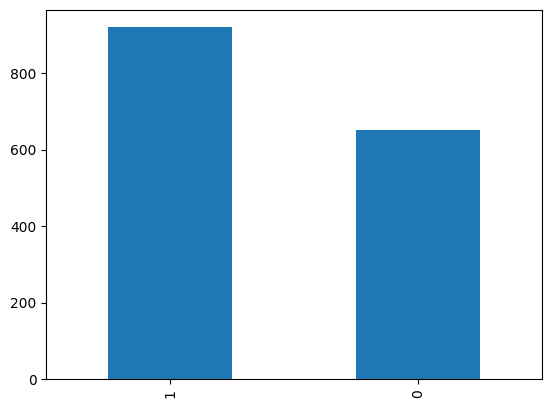

In [242]:
df_new["readmitted"].value_counts().plot(kind="bar")

# Model training and Validation

In [246]:
input = df_new.drop(['readmitted'],axis=1)
label = df_new['readmitted']


In [249]:
smt = SMOTE(random_state=20)
X_train_old, X_test, Y_train_old, Y_test = train_test_split(input, label, test_size=0.20, random_state=0)

X_train, Y_train = smt.fit_resample(X_train_old, Y_train_old)
X_train = pd.DataFrame(X_train, columns=list(X_train_old.columns))

print("nums of train/test set: ", len(X_train), len(X_test), len(Y_train), len(Y_test))


print('--- XGBoost model ---')
xg_reg = xgb.XGBClassifier()

xg_reg.fit(X_train, Y_train)


Y_test_predict = xg_reg.predict(X_test)
acc = accuracy_score(Y_test, Y_test_predict)
mat = confusion_matrix(Y_test, Y_test_predict)
f1 = f1_score(Y_test, Y_test_predict, average='weighted')
print("Accuracy: ", acc)
print("F1 score: ", f1)
print("Confusion matrix: \n", mat)
print('Overall report: \n', classification_report(Y_test, Y_test_predict))


nums of train/test set:  1466 314 1466 314
--- XGBoost model ---
Accuracy:  0.6305732484076433
F1 score:  0.6272612770178554
Confusion matrix: 
 [[ 64  64]
 [ 52 134]]
Overall report: 
               precision    recall  f1-score   support

           0       0.55      0.50      0.52       128
           1       0.68      0.72      0.70       186

    accuracy                           0.63       314
   macro avg       0.61      0.61      0.61       314
weighted avg       0.63      0.63      0.63       314

